In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.activations import relu

Load the Elspotprices Data

In [2]:

# We load the spot prices
file_Path = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_Path)

# We convert the HourUTC column to datetime and set the column only at the DK2 price area
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

definere train og test

Note: der er intilvidre ikke val, da der ikke er nogle hyerpalermeter der skal varieres

In [3]:

sc = MinMaxScaler(feature_range=(0, 1))

data_training = sc.fit_transform(df_prices["SpotPriceDKK"].values.reshape(-1,1))


start_date_test = pd.to_datetime('2023-11-28 00:00:00')
end_date_test = pd.to_datetime('2023-12-31 23:00:00')

start_date_train = pd.to_datetime('2019-01-01 00:00:00')
end_date_train = pd.to_datetime('2023-12-01 23:00:00')

train_data = df_prices.loc[(df_prices['HourUTC']>=start_date_train) & (df_prices['HourUTC']<=end_date_train)]
train_data = sc.fit_transform(train_data["SpotPriceDKK"].values.reshape(-1,1))  

test_data = df_prices.loc[(df_prices['HourUTC']>=start_date_test) & (df_prices['HourUTC']<=end_date_test)]
test_data = sc.transform(test_data["SpotPriceDKK"].values.reshape(-1,1))



Parameter 

In [4]:
look_back = (24*3) # Number of previous time steps to use as input features
look_ahead = 24# Number of time steps to look ahead

Split Data i seqenser 

Note der er et problem med at den mister den sidste dag, men tænker at løse det efter der er tilføjet exoginos

In [5]:

def create_sequences(data, seq_length, pred_length):
    X = []
    y = []

    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[(i + seq_length):(i + seq_length + pred_length)])

    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, look_back, look_ahead)
X_test, y_test = create_sequences(test_data, look_back, look_ahead)


n_train = len(X_train)
#n_val = len(X_val)
n_test = len(X_test)
n_data = len(df_prices)

print(f"Training samples: {n_train}")
#print(f"Validation samples: {n_val}")
print(f"Testing samples: {n_test}")
print(f"Total samples: {n_data}")


Training samples: 43008
Testing samples: 720
Total samples: 43824


Byg og træn model 

In [6]:

dropout = 0.2
# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=look_ahead, return_sequences=True, input_shape=(X_train.shape[1], 1), recurrent_dropout=dropout, dropout=dropout)) # bedre uden activation="relu",
print(X_train.shape[1])
model.add(LSTM(units=look_ahead))
model.add(Dense(units=24))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32 )#validation_data=(X_val, y_val)


72
Epoch 1/5
1344/1344 [==============================] - 103s 76ms/step - loss: 0.0041
Epoch 2/5
1344/1344 [==============================] - 101s 75ms/step - loss: 0.0035
Epoch 3/5
1344/1344 [==============================] - 100s 74ms/step - loss: 0.0033
Epoch 4/5
1344/1344 [==============================] - 3235s 2s/step - loss: 0.0030
Epoch 5/5
1344/1344 [==============================] - 98s 73ms/step - loss: 0.0028


Lav forudsigelse Og plot

No handles with labels found to put in legend.


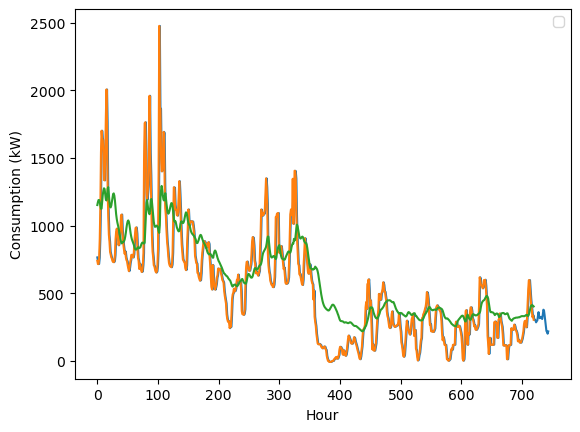

In [7]:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test) 


last_x_prices = df_prices['SpotPriceDKK'].iloc[-(len(X_test)+24):]

y_test_org = np.array([])

# Append the last 798 values to the new array
y_test_org = np.append(y_test_org, last_x_prices)

y_test = np.squeeze(y_test)
y_test_orginal = sc.inverse_transform(y_test)
predicted_consumption = sc.inverse_transform(y_pred)

y_avage_pred = np.mean(predicted_consumption, axis=1)

plt.plot(y_test_org)
plt.plot(y_test_orginal[:, 1])
plt.plot(y_avage_pred)

plt.xlabel('Hour')
plt.ylabel('Consumption (kW)')
plt.legend()
plt.show()

traning Loss per ephoc

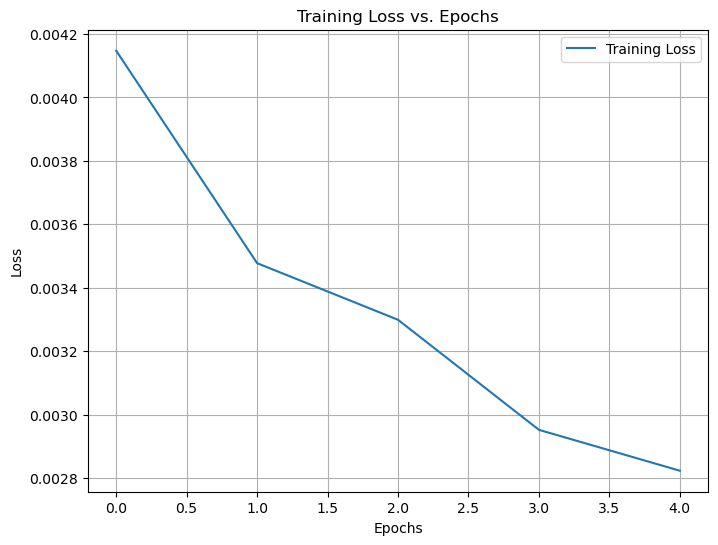

In [8]:


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test[:, 1], np.mean(y_pred, axis=1))
mae = mean_absolute_error(y_test[:, 1], np.mean(y_pred, axis=1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test[:, 1], np.mean(y_pred, axis=1))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 0.0011855757439679657
Mean Absolute Error (MAE): 0.026962213453523544
Root Mean Squared Error (RMSE): 0.03443219051945382
R-squared (R2) Score: 0.6509159643512039
